In [43]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

try:
#     import setGPU
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "6"
except:
    print('no setGPU')

In [44]:
sent = "안녕 12345 이힛asdfasdf 2ㅏ34ㅓㄲ꺼져"

sent_clean = re.sub("[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]", " ", sent)
print(sent_clean)

안녕 12345 이힛asdfasdf 2ㅏ34ㅓㄲ꺼져


In [45]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [46]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

# BASE PARAM

BATCH_SIZE = 128
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 31 * 2 # Average total * 2

DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [47]:
# 토크나이저 종류 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased", cache_dir='bert_ckpt', do_lower_case=True)
# tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

I0629 15:44:22.472619 140140896171840 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt from cache at bert_ckpt/bb773818882b0524dc53a1b31a2cc95bc489f000e7e19773ba07846011a6c711.535306b226c42cebebbc0dabc83b92ab11260e9919e21e2ab0beb301f267b4c7


# KorNLI Dataset

Data from Kakaobrain:  https://github.com/kakaobrain/KorNLUDatasets

In [48]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna()
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

 32%|███▏      | 306066/942808 [03:20<06:29, 1634.41it/s]

Total # dataset: train - 942808, dev - 2490


In [49]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two setenece input
    
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [50]:
# train_data_snli_xnli = train_data_snli_xnli[:100]

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in tqdm(zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']),
                         total=len(train_data_snli_xnli)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
train_snli_xnli_input_ids = np.array(input_ids, dtype=int)
train_snli_xnli_attention_masks = np.array(attention_masks, dtype=int)
train_snli_xnli_type_ids = np.array(token_type_ids, dtype=int)
train_snli_xnli_inputs = (train_snli_xnli_input_ids, train_snli_xnli_attention_masks, train_snli_xnli_type_ids)


  2%|▏         | 22563/942808 [00:14<09:57, 1539.50it/s]


  5%|▍         | 44692/942808 [00:28<09:43, 1538.26it/s]


  7%|▋         | 66738/942808 [00:43<09:06, 1602.27it/s]


  9%|▉         | 88469/942808 [00:57<09:05, 1566.86it/s]


 12%|█▏        | 110244/942808 [01:12<08:24, 1651.31it/s]


 14%|█▍        | 130972/942808 [01:26<08:57, 1509.26it/s]


 16%|█▌        | 152212/942808 [01:40<08:52, 1485.46it/s]


 18%|█▊        | 173188/942808 [01:55<08:49, 1454.04it/s]


 21%|██        | 194113/942808 [02:09<08:37, 1446.52it/s]


 23%|██▎       | 215360/942808 [02:23<07:28, 1621.94it/s]


 25%|██▌       | 236834/942808 [02:37<08:18, 1416.43it/s]


 27%|██▋       | 258166/942808 [02:52<07:40, 1488.17it/s]


 30%|██▉       | 279378/942808 [03:06<07:42, 1434.11it/s]


 32%|███▏      | 300536/942808 [03:21<07:04, 1511.93it/s]


 34%|███▍      | 322268/942808 [03:35<06:40, 1550.26it/s]


 37%|███▋      | 344144/942808 [03:49<06:42, 1487.50it/s]


 39%|███▊      | 365276/942808 [04:03<06:15, 1538.29it/s]


 41%|████      | 387215/942808 [04:17<06:39, 1391.48it/s]


 43%|████▎     | 409213/942808 [04:31<05:26, 1633.08it/s]


 46%|████▌     | 431121/942808 [04:46<05:39, 1508.04it/s]


 48%|████▊     | 452871/942808 [05:00<04:51, 1681.56it/s]


 50%|█████     | 474727/942808 [05:14<05:08, 1516.04it/s]


 53%|█████▎    | 496476/942808 [05:28<04:35, 1620.81it/s]


 55%|█████▍    | 518158/942808 [05:42<04:35, 1542.58it/s]


 57%|█████▋    | 540600/942808 [05:56<03:59, 1677.28it/s]


 59%|█████▉    | 559288/942808 [06:10<05:44, 1112.94it/s]


 61%|██████    | 574850/942808 [06:26<05:22, 1142.05it/s]


 63%|██████▎   | 590339/942808 [06:40<05:05, 1153.66it/s]


 64%|██████▍   | 605179/942808 [06:54<05:55, 948.89it/s]


 66%|██████▌   | 620166/942808 [07:08<04:54, 1094.02it/s]


 67%|██████▋   | 634774/942808 [07:23<04:40, 1100.03it/s]


 69%|██████▉   | 649677/942808 [07:37<04:44, 1031.10it/s]


 70%|███████   | 664407/942808 [07:51<04:29, 1032.01it/s]


 72%|███████▏  | 678963/942808 [08:05<04:26, 988.38it/s]


 74%|███████▎  | 694746/942808 [08:19<03:44, 1102.81it/s]


 75%|███████▌  | 710721/942808 [08:34<03:11, 1212.51it/s]


 77%|███████▋  | 726688/942808 [08:48<03:13, 1116.36it/s]


 79%|███████▊  | 742327/942808 [09:02<03:02, 1097.87it/s]


 80%|████████  | 758048/942808 [09:16<02:39, 1158.07it/s]


 82%|████████▏ | 773615/942808 [09:32<02:30, 1121.84it/s]


 84%|████████▎ | 789419/942808 [09:46<02:12, 1161.68it/s]


 85%|████████▌ | 805418/942808 [10:00<02:03, 1114.61it/s]


 87%|████████▋ | 821254/942808 [10:14<01:46, 1144.93it/s]


 89%|████████▉ | 836856/942808 [10:28<01:28, 1193.07it/s]


 90%|█████████ | 852798/942808 [10:42<01:23, 1079.67it/s]


 92%|█████████▏| 868257/942808 [10:56<01:07, 1100.34it/s]


 94%|█████████▎| 883877/942808 [11:10<00:56, 1050.19it/s]


 95%|█████████▌| 899602/942808 [11:24<00:37, 1142.00it/s]


 97%|█████████▋| 915296/942808 [11:38<00:26, 1055.44it/s]


 99%|█████████▊| 930541/942808 [11:52<00:11, 1079.88it/s]


100%|██████████| 942808/942808 [12:04<00:00, 1301.85it/s]

# DEV SET Preprocessing

In [51]:
# dev_data_xnli = dev_data_xnli[:50]

# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in tqdm(zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2'])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_xnli_input_ids = np.array(input_ids, dtype=int)
dev_xnli_attention_masks = np.array(attention_masks, dtype=int)
dev_xnli_type_ids = np.array(token_type_ids, dtype=int)
dev_xnli_inputs = (dev_xnli_input_ids, dev_xnli_attention_masks, dev_xnli_type_ids)


0it [00:00, ?it/s]
121it [00:00, 1206.60it/s]
253it [00:00, 1237.47it/s]
382it [00:00, 1250.78it/s]
510it [00:00, 1254.31it/s]
607it [00:00, 1099.47it/s]
701it [00:00, 977.07it/s] 
823it [00:00, 1035.52it/s]
967it [00:00, 1130.55it/s]
1085it [00:00, 1141.73it/s]
1199it [00:01, 1135.29it/s]
1321it [00:01, 1157.98it/s]
1437it [00:01, 1081.92it/s]
1552it [00:01, 1100.21it/s]
1669it [00:01, 1118.64it/s]
1782it [00:01, 1088.16it/s]
1895it [00:01, 1099.93it/s]
2006it [00:01, 1075.69it/s]
2128it [00:01, 1114.77it/s]
2248it [00:01, 1137.05it/s]
2363it [00:02, 1131.73it/s]
2477it [00:02, 1094.54it/s]
2490it [00:02, 1118.73it/s]

In [52]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


In [53]:
class TFBertClassifier(TFBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        
        self.num_labels = 3        
        self.bert = TFBertMainLayer(config, name="bert")
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(config.num_labels, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

bert_config = BertConfig() # 기본 버트 파라메터
cls_model = TFBertClassifier(bert_config).from_pretrained("bert-base-multilingual-uncased", cache_dir='bert_ckpt')
# cls_model = TFBertClassifier(bert_config).from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

I0629 15:57:03.610844 140140896171840 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at bert_ckpt/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc
I0629 15:57:03.612658 140140896171840 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_positio

In [54]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [55]:
#학습 진행하기
model_name = "tf2_KorNLI"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_snli_xnli_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_xnli_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

data_out/KOR/tf2_KorNLI -- Folder already exists 

Train on 942808 samples, validate on 2490 samples
Epoch 1/3
942720/942808 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.3333
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to data_out/KOR/tf2_KorNLI/weights.h5
942808/942808 [==============================] - 3841s 4ms/sample - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 2/3
942720/942808 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.3333
Epoch 00002: val_accuracy did not improve from 0.33333
942808/942808 [==============================] - 3816s 4ms/sample - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 3/3
942720/942808 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.3333
Epoch 00003: val_accuracy did not improve from 0.33333
942808/942808 [==============================] - 3817s 4ms/sample - loss: nan - accuracy: 0.3333 - val_loss: nan - 

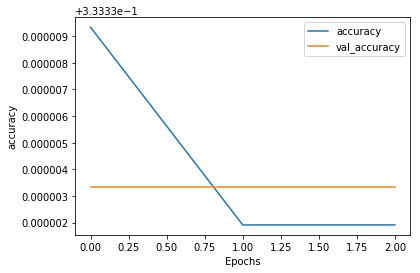

In [56]:
plot_graphs(history, 'accuracy')

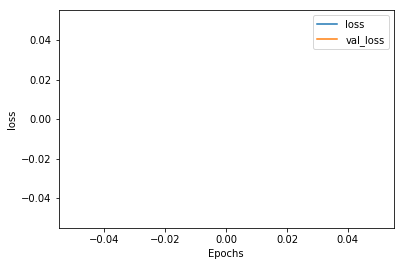

In [57]:
plot_graphs(history, 'loss')

# KorNLI Test dataset

In [58]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
test_data_xnli = test_data_xnli.dropna()
test_data_xnli.head()

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment


In [59]:
# Test set도 똑같은 방법으로 구성한다.

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in tqdm(zip(test_data_xnli['sentence1'], test_data_xnli['sentence2'])):
    
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
    
test_xnli_input_ids = np.array(input_ids, dtype=int)
test_xnli_attention_masks = np.array(attention_masks, dtype=int)
test_xnli_type_ids = np.array(token_type_ids, dtype=int)
test_xnli_inputs = (test_xnli_input_ids, test_xnli_attention_masks, test_xnli_type_ids)


0it [00:00, ?it/s]
118it [00:00, 1167.93it/s]
260it [00:00, 1233.01it/s]
410it [00:00, 1300.97it/s]
562it [00:00, 1357.84it/s]
721it [00:00, 1419.00it/s]
869it [00:00, 1433.84it/s]
1024it [00:00, 1464.67it/s]
1163it [00:00, 1317.93it/s]
1292it [00:00, 1303.42it/s]
1421it [00:01, 1269.45it/s]
1549it [00:01, 1271.86it/s]
1684it [00:01, 1292.94it/s]
1833it [00:01, 1343.77it/s]
1974it [00:01, 1359.14it/s]
2111it [00:01, 1318.57it/s]
2244it [00:01, 1224.43it/s]
2369it [00:01, 1221.67it/s]
2493it [00:01, 1214.74it/s]
2616it [00:01, 1216.68it/s]
2739it [00:02, 1164.81it/s]
2857it [00:02, 1143.05it/s]
2972it [00:03, 333.84it/s] 
3096it [00:03, 427.45it/s]
3231it [00:03, 537.61it/s]
3359it [00:03, 650.68it/s]
3492it [00:03, 767.57it/s]
3612it [00:03, 849.91it/s]
3740it [00:03, 944.23it/s]
3870it [00:03, 1027.44it/s]
4001it [00:03, 1097.73it/s]
4129it [00:04, 1145.91it/s]
4256it [00:04, 1058.28it/s]
4372it [00:04, 1057.36it/s]
4502it [00:04, 1120.02it/s]
4624it [00:04, 1147.95it/s]
4743it [00:0

In [60]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_xnli_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_xnli_input_ids), len(test_data_xnli_labels)))

# sents: 5010, # labels: 5010


In [61]:
results = cls_model.evaluate(test_xnli_inputs, test_data_xnli_labels, batch_size=512)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 6s 1ms/sample - loss: nan - accuracy: 0.3333
test loss, test acc:  [nan, 0.33333334]
